In [1]:
%load_ext autoreload
%autoreload 2

In [171]:
from HelperClasses import ClassificationModel, DataHandler, UCRDataset
from pyts.datasets import fetch_ucr_dataset
from tslearn.datasets import UCR_UEA_datasets
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.preprocessing import MinMaxScaler
import sklearn
import os
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

from tslearn.shapelets import LearningShapelets

In [9]:
def scale_dataset(traindata, testdata):
    minmaxscaler = MinMaxScaler()
    minmaxscaler.fit(traindata.reshape(-1, 1))

    scaled_traindata = minmaxscaler.transform(traindata.reshape(-1, 1)).reshape(-1, traindata.shape[1], 1)
    scaled_testdata = minmaxscaler.transform(testdata.reshape(-1, 1)).reshape(-1, testdata.shape[1], 1)
    return scaled_traindata, scaled_testdata


def getAreasFromGradCam(gradcam0, gradcam1, threshold):
    gradcam = np.fmax(gradcam0, gradcam1)
    above_threshold = gradcam > threshold
    areas = []
    start = None
    end = None
    for i, j in enumerate(above_threshold):
        if j & (start is None):
            start = i
        if (not j) & (start is not None):
            end = i
            areas.append([start, end])
            start = None
            end = None
    if start is not None:
        areas.append([start, len(above_threshold)])
    return areas


def getAreasFromLearningShapelets(locations, shapelets):
    return [[[location, location + length] for location, length in zip(sample_locations, [len(s) for s in shapelets])] for sample_locations in locations]


def plot_ts(ts_sample):
    ts, label = ts_sample
    plt.figure(figsize=(10, 4))
    plt.plot(ts, label="Time Series", color='blue')
    plt.title(f"Time Series Plot (Class Label: {label})")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Display grid and legend
    plt.grid(False)
    # plt.legend()
    plt.show()


def calculateConfidence(cnn_model, X, y):
    confidences = cnn_model.getConfidences(X)
    return 1 - (float(sum(abs(confidences - cnn_model.enc.transform(y.reshape(-1,1))))[0]) / len(y))


def generate_random_areas(total_length_of_time_series, number, size):
  
    if number * size > total_length_of_time_series:
        raise ValueError("Cannot fit the requested number of areas of the given size within the total length.")
    
    areas = []
    available_indices = list(range(total_length_of_time_series))  # All possible indices
    
    while len(areas) < number:
        start = random.choice(available_indices)  # Randomly pick a starting point
        end = start + size

        # Check if the area fits within the time series
        if end > total_length_of_time_series:
            continue

        # Check if the area overlaps with any existing area
        overlap = any(max(start, existing[0]) < min(end, existing[1]) for existing in areas)
        if overlap:
            continue

        # If no overlap, add the area and remove these indices from the pool
        areas.append([start, end])
        available_indices = [i for i in available_indices if i < start or i >= end]

    areas.sort(key=lambda x: x[0])
    
    return areas

In [88]:
datasets = [{"name": "Coffee", 0: "Robusta", 1: "Arabica"}, 
            {"name": "GunPoint", 1: "Gun", 2: "No Gun"},
            {"name": "PowerCons", 1: "Warm season", 2: "Cold Season"},
            {"name": "ECG200", -1: "Normal Heartbeat", 1: "Myocardial Infarction"}]

In [71]:
dataset = datasets[3] ### Hier Datensatz auswählen
dataset_name = dataset["name"]

train_x, train_y, test_x, test_y = UCR_UEA_datasets().load_dataset(dataset_name)
train_x, test_x = scale_dataset(train_x, test_x)

data = DataHandler(train_x, test_x, train_y, test_y)
dataset_name

'ECG200'

In [87]:
train_y

array([-1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,
        1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1,  1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1,  1])

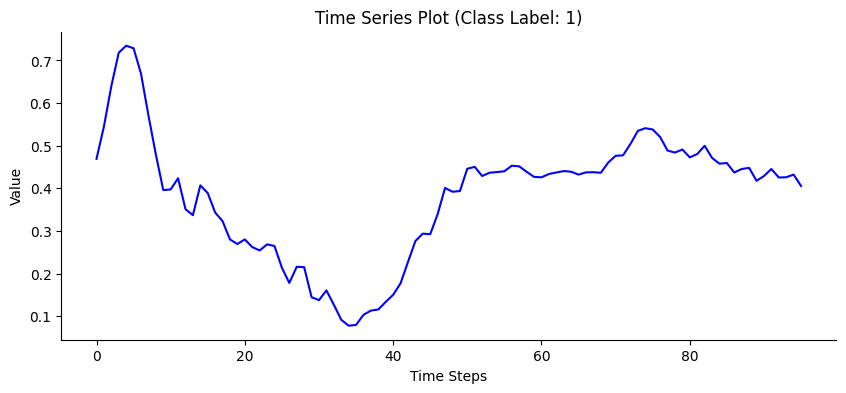

In [74]:
plot_ts([train_x[40], train_y[40]])

# CNN

In [79]:
cnn_model = ClassificationModel(train_x, train_y)

In [80]:
cnn_model.fit(train_x, train_y, num_epochs=100)

Epoch [1/100], Loss: 0.6230
Epoch [2/100], Loss: 0.6164
Epoch [3/100], Loss: 0.5701
Epoch [4/100], Loss: 0.5472
Epoch [5/100], Loss: 0.5065
Epoch [6/100], Loss: 0.5036
Epoch [7/100], Loss: 0.4943
Epoch [8/100], Loss: 0.4728
Epoch [9/100], Loss: 0.4752
Epoch [10/100], Loss: 0.4931
Epoch [11/100], Loss: 0.4615
Epoch [12/100], Loss: 0.4585
Epoch [13/100], Loss: 0.4474
Epoch [14/100], Loss: 0.4414
Epoch [15/100], Loss: 0.4559
Epoch [16/100], Loss: 0.4316
Epoch [17/100], Loss: 0.4225
Epoch [18/100], Loss: 0.3997
Epoch [19/100], Loss: 0.3968
Epoch [20/100], Loss: 0.3819
Epoch [21/100], Loss: 0.3867
Epoch [22/100], Loss: 0.3871
Epoch [23/100], Loss: 0.3933
Epoch [24/100], Loss: 0.3715
Epoch [25/100], Loss: 0.3821
Epoch [26/100], Loss: 0.3602
Epoch [27/100], Loss: 0.3536
Epoch [28/100], Loss: 0.3639
Epoch [29/100], Loss: 0.3496
Epoch [30/100], Loss: 0.3595
Epoch [31/100], Loss: 0.3556
Epoch [32/100], Loss: 0.3532
Epoch [33/100], Loss: 0.3491
Epoch [34/100], Loss: 0.3467
Epoch [35/100], Loss: 0

In [85]:
# To save model
cnn_model.save_model(f"./models/{dataset_name}_cnn.pth")

In [ ]:
# To load model
cnn_model = ClassificationModel(train_x, train_y)
cnn_model.load_model(f"./models/{dataset_name}_cnn_final.pth")

In [82]:
cnn_model.test(train_x, train_y)

Test Accuracy: 97.00%


In [54]:
cnn_model.classify(1, test_x, test_y) # Index, X, y - Returns predicted Label, true Label

(0, 0)

In [55]:
threshold = 0.35
cnn_areas = []

for x, y in [[train_x, train_y], [test_x, test_y]]:
    dataset_areas = []
    for i in range(len(x)):
        cam_0 = cnn_model.grad_cam(i, x, y, 0)
        cam_1 = cnn_model.grad_cam(i, x, y, 1)
        dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
    cnn_areas.append(dataset_areas)

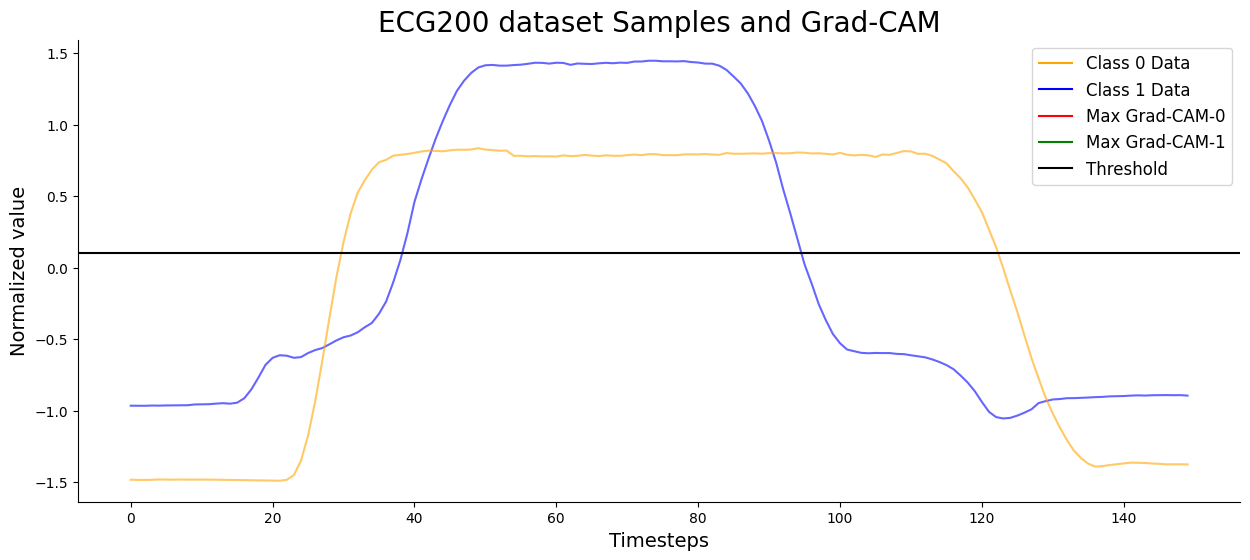

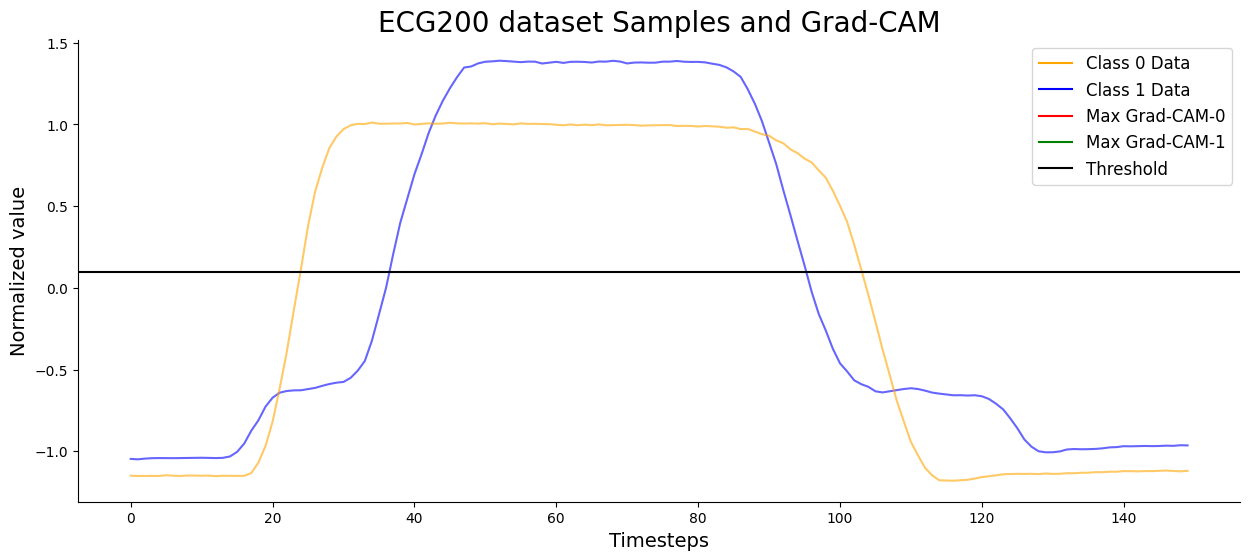

In [116]:
for x, y in [[train_x[30:32], train_y[30:32]], [test_x[20:22], test_y[20:22]]]:
# for x, y in [[train_x, train_y], [test_x, test_y]]:


    time_axis = np.arange(test_x.shape[1])
    plt.figure(figsize=(15, 6))

    # Initialize arrays for Grad-CAM maxima
    max_cam_0 = np.zeros_like(time_axis, dtype=float)
    max_cam_1 = np.zeros_like(time_axis, dtype=float)

    for i in range(len(x)):

        # Visualization
        color = 'blue' if y[i] == 1 else 'orange'
        plt.plot(time_axis, x[i], label="Input Time Series", color=color, alpha=0.6)

        # # Compute Grad-CAM for class 0
        # cam_0 = cnn_model.grad_cam(i, x, y, 0)
        # max_cam_0 = np.fmax(max_cam_0, cam_0)
        # plt.plot(time_axis, cam_0, alpha=0.8, label="Max Grad-CAM-0", color="red")

        # # Compute Grad-CAM for class 1
        # cam_1 = cnn_model.grad_cam(i, x, y, 1)
        # max_cam_1 = np.fmax(max_cam_1, cam_1)
        # plt.plot(time_axis, cam_1, alpha=0.8, label="Max Grad-CAM-1", color="green")


    # Add grey shaded areas where Grad-CAM max values exceed the threshold
    above_threshold_0 = max_cam_0 > threshold
    above_threshold_1 = max_cam_1 > threshold

    for i in range(1, len(time_axis)):
        if above_threshold_0[i]:
            plt.axvspan(time_axis[i - 1], time_axis[i], color='red', alpha=0.15, lw=0)

    for i in range(1, len(time_axis)):
        if above_threshold_1[i]:
            plt.axvspan(time_axis[i - 1], time_axis[i], color='green', alpha=0.15, lw=0)

    # Add title, labels, and legend
    # pltyormalized Value", fontdict = {'fontsize' : 14})
    plt.axhline(y=threshold, color="black")
    colors = ['orange', 'blue', 'red', 'green', 'black']
    lines = [Line2D([0], [0], color=c) for c in colors]
    labels = ['Class 0 Data', 'Class 1 Data', 'Max Grad-CAM-0', 'Max Grad-CAM-1', 'Threshold']
    plt.legend(lines, labels, prop={'size': 12})
    plt.gca().set_ylabel("Normalized value", fontdict={'fontsize' : 14})
    plt.gca().set_xlabel("Timesteps", fontdict={'fontsize' : 14})
    plt.gca().set_title(f"{dataset_name} dataset Samples and Grad-CAM", fontdict = {'fontsize' : 20})
    plt.gca().spines[["top", "right"]].set_visible(False)

    plt.show()


In [124]:
data = DataHandler(train_x, test_x, train_y, test_y)

In [125]:
mcnn_train_x, mcnn_test_x, mcnn_train_y, mcnn_test_y = data.getData(how="zero", all_areas=cnn_areas, invert=False)

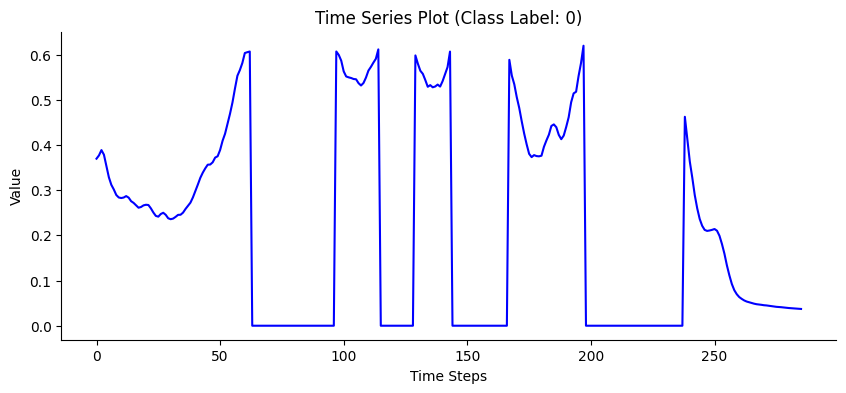

In [126]:
plot_ts([mcnn_train_x[6], mcnn_train_y[6]])

# LearningShapelets

In [127]:
avg_cnn_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
avg_cnn_area_size

109.32142857142857

In [128]:
number_shapelets = 3
shapelet_length = int(avg_cnn_area_size / number_shapelets)
shapelet_length

36

In [133]:
ls_model = LearningShapelets(n_shapelets_per_size={shapelet_length: number_shapelets}, scale=False)
ls_model.fit(train_x, train_y)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(n_shapelets_per_size={36: 3})

In [134]:
ls_areas = []
for x, y in [[train_x, train_y], [test_x, test_y]]:
    ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

In [135]:
avg_ls_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in ls_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
avg_ls_area_size

108.0

In [136]:
mls_train_x, mls_test_x, mls_train_y, mls_test_y = data.getData(how="zero", all_areas=ls_areas, invert=False)

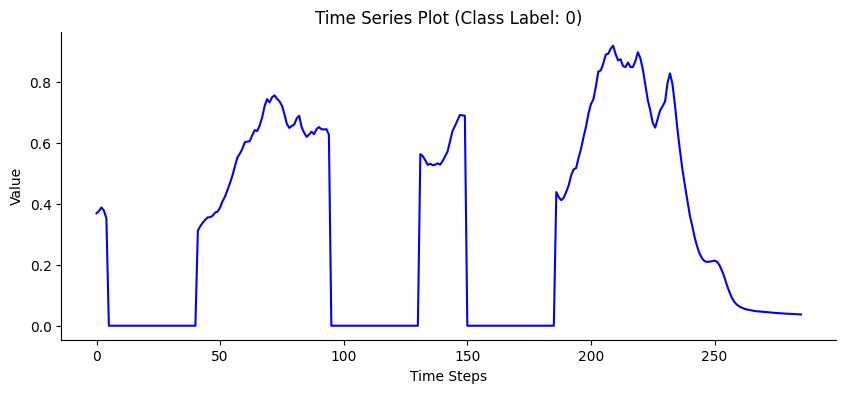

In [137]:
plot_ts([mls_train_x[6], mls_train_y[6]])

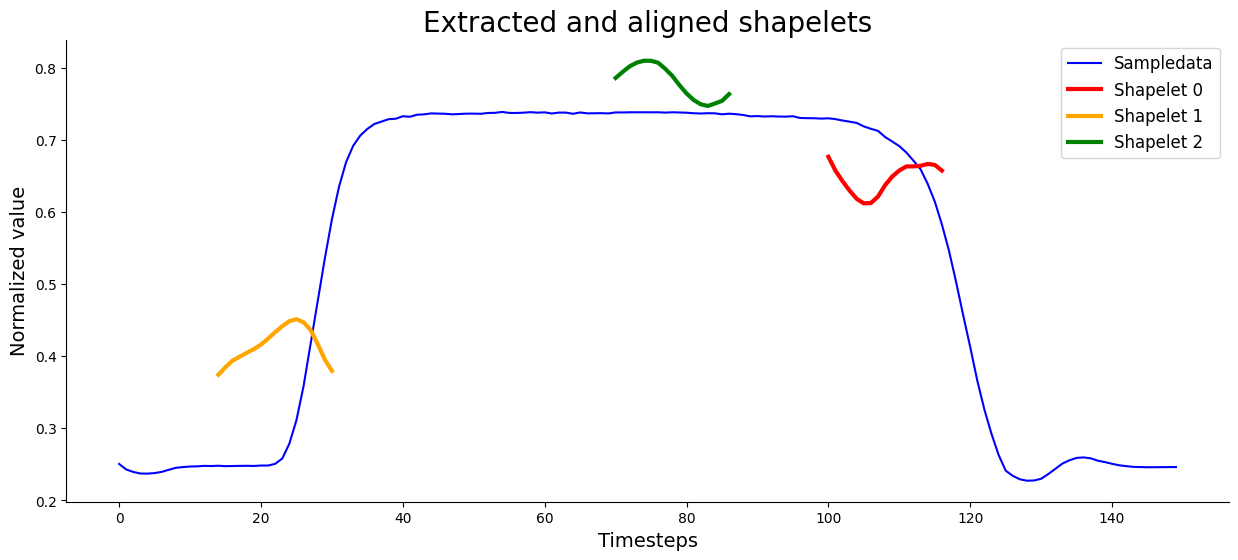

In [111]:
distances = ls_model.transform(train_x) # Do not use since distances come from blackbox model and are not the same as manually calculated distances
predicted_locations = ls_model.locate(train_x)

fig, ax = plt.subplots(figsize=(15, 6))

# Plot the shapelet and align it on the best matched time series. The optimizer
# will often enlarge the shapelet to create a larger gap between the distances
# of both classes. We therefore normalize the shapelet again before plotting.

test_ts_id = 6 #np.argmin(np.sum(distances, axis=1))
id_shap = 0

colors = ["red", "orange", "green", "black", "purple"]

ax.plot(train_x[test_ts_id].ravel(), color='blue', label="Sampledata")
for id_shap in range(len(ls_model.shapelets_)):
    shap = ls_model.shapelets_[id_shap]
    #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
    pos = predicted_locations[test_ts_id, id_shap]
    ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap], label=f"Shapelet {id_shap}")
    # ax.axvline(pos, color='k', linestyle='--', alpha=0.25)

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)
ax.legend(prop={'size': 12})

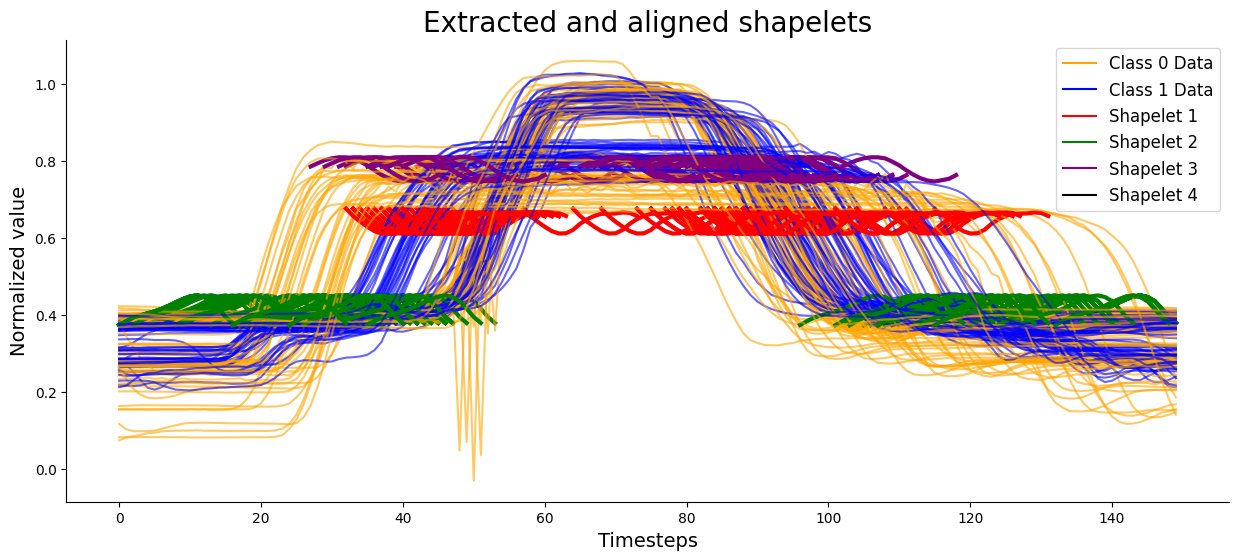

In [108]:
test_dataset = UCRDataset(test_x.astype(np.float32),test_y.astype(np.float32))
predicted_locations = ls_model.locate(test_x)

time_axis = np.arange(train_x.shape[1])
fig, ax = plt.subplots(figsize=(15, 6))

colors = ["red", "green", "purple", "black", "yellow"]

for test_ts_id in range(len(test_dataset)):
    input_tensor = test_dataset[test_ts_id][0]
    label = test_dataset[test_ts_id][1]

    # Visualization
    color = 'blue' if label == 1 else 'orange'
    ax.plot(time_axis, input_tensor, label="Input Time Series", color=color, alpha=0.6)

    for id_shap in range(len(ls_model.shapelets_)):
        shap = ls_model.shapelets_[id_shap]
        #shap = TimeSeriesScalerMinMax().fit_transform(shap.reshape(1, -1, 1)).flatten()
        pos = predicted_locations[test_ts_id, id_shap]
        ax.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap])

ax.set_ylabel("Normalized value", fontdict={'fontsize' : 14})
ax.set_xlabel("Timesteps", fontdict={'fontsize' : 14})
ax.set_title("Extracted and aligned shapelets", fontdict = {'fontsize' : 20})
ax.spines[['right', 'top']].set_visible(False)

colors = ['orange', 'blue', 'red', 'green', 'purple', 'black']
lines = [Line2D([0], [0], color=c) for c in colors]
labels = ['Class 0 Data', 'Class 1 Data', 'Shapelet 1', 'Shapelet 2', 'Shapelet 3', 'Shapelet 4']
plt.legend(lines, labels, prop={'size': 12})

# Evaluation

In [118]:
def getMeanConfidences(X):
    confidences = cnn_model.getConfidences(X)
    confidences0 = [confidence for confidence in confidences if confidence[0] > confidence[1]]
    confidences1 = [confidence for confidence in confidences if confidence[0] < confidence[1]]
    return np.mean([confidence[0] for confidence in confidences0]), len(confidences0), np.mean([confidence[1] for confidence in confidences1]), len(confidences1)


In [149]:
confidences = cnn_model.getConfidences(test_x)

confidences0 = [confidence for confidence in confidences if confidence[0] > confidence[1]]
confidences1 = [confidence for confidence in confidences if confidence[0] < confidence[1]]

np.mean([confidence[0] for confidence in confidences0])
np.mean([confidence[1] for confidence in confidences1])

0.9902562

In [122]:
getMeanConfidences(mls_train_x)

(0.9996958, 1, 0.99994135, 49)

In [133]:
mls_train_y

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

In [150]:
cnn_model.test(test_x, test_y)

Test Accuracy: 94.67%


In [141]:
cnn_model.test(mcnn_train_x, mcnn_train_y)

Test Accuracy: 64.00%


In [131]:
cnn_model.classify(-1, train_x, train_y)

(1, 1)

In [159]:

float(sum(abs(confidences - cnn_model.enc.transform(mcnn_test_y.reshape(-1,1))))[0]) / len(mcnn_test_y)

0.0524473342399533

In [158]:
len(test_y)

150

In [166]:
# The confidence of a dataset is 1 minus the average absolute deviation of the first one-hot encoded class and the corresponding probability given by the model
calculateConfidence(cnn_model, test_x, mls_test_y)

0.9475526657600467

In [147]:
random_areas = []
for x, y in [[train_x, train_y], [test_x, test_y]]:
    temp = []
    for ts in x:
        temp.append(generate_random_areas(train_x.shape[1], 3, 30))
    random_areas.append(temp)

In [150]:
avg_rand_area_size = np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in random_areas for sample_areas in dataset_areas]) #### Average length of combined CNN areas
avg_rand_area_size

90.0

In [148]:
random_areas

[[[[40, 70], [110, 140], [170, 200]],
  [[23, 53], [129, 159], [199, 229]],
  [[25, 55], [183, 213], [215, 245]],
  [[27, 57], [57, 87], [175, 205]],
  [[11, 41], [77, 107], [234, 264]],
  [[26, 56], [135, 165], [173, 203]],
  [[33, 63], [139, 169], [215, 245]],
  [[2, 32], [64, 94], [185, 215]],
  [[41, 71], [130, 160], [168, 198]],
  [[95, 125], [169, 199], [236, 266]],
  [[122, 152], [192, 222], [245, 275]],
  [[101, 131], [145, 175], [213, 243]],
  [[16, 46], [179, 209], [252, 282]],
  [[36, 66], [154, 184], [187, 217]],
  [[23, 53], [120, 150], [234, 264]],
  [[26, 56], [136, 166], [178, 208]],
  [[61, 91], [167, 197], [227, 257]],
  [[70, 100], [175, 205], [207, 237]],
  [[13, 43], [103, 133], [236, 266]],
  [[13, 43], [142, 172], [204, 234]],
  [[10, 40], [82, 112], [123, 153]],
  [[21, 51], [92, 122], [242, 272]],
  [[36, 66], [75, 105], [153, 183]],
  [[11, 41], [172, 202], [223, 253]],
  [[97, 127], [156, 186], [227, 257]],
  [[17, 47], [118, 148], [163, 193]],
  [[10, 40], [

# Validation Loop

Variables: 

-threshold for sizes of CNN-areas (number of areas automatically determined by grad-cam)

-number of shapelets (corresponding sizes are determined by size of CNN-areas)

-mode of cancellation (zero, linear or mean)

-inverted areas (true, false) --> can the areas determined as important alone cause good confidence levels?

Compare to original dataset as baseline

In [118]:
datasets = [{"name": "Coffee", 0: "Robusta", 1: "Arabica"}, 
            {"name": "GunPoint", 1: "Gun", 2: "No Gun"},
            {"name": "PowerCons", 1: "Warm season", 2: "Cold Season"},
            {"name": "ECG200", -1: "Normal Heartbeat", 1: "Myocardial Infarction"}]

In [135]:
train_x, train_y, test_x, test_y = UCR_UEA_datasets().load_dataset("PowerCons")
train_x, test_x = scale_dataset(train_x, test_x)

In [136]:
if f"PowerCons_cnn_final.pth" in os.listdir("models"):
    cnn_model = ClassificationModel(train_x, train_y)
    cnn_model.load_model(f"./models/PowerCons_cnn_final.pth")

In [145]:
tartget_area_size = int(train_x.shape[1] * 0.3)
tartget_area_size

43

In [149]:
threshold = 0.5
mx = 1
mn = 0

for j in range(10):

    cnn_areas = []
    for x, y in [[train_x, train_y], [test_x, test_y]]:
        dataset_areas = []
        for i in range(len(x)):
            cam_0 = cnn_model.grad_cam(i, x, y, 0)
            cam_1 = cnn_model.grad_cam(i, x, y, 1)
            dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
        cnn_areas.append(dataset_areas)

    avg_cnn_area_size = int(np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]))
    print(avg_cnn_area_size)

    if avg_cnn_area_size == tartget_area_size:
        break
    elif avg_cnn_area_size < tartget_area_size:
        mx = threshold
    elif avg_cnn_area_size > tartget_area_size:
        mn = threshold

    threshold = mn + ((mx - mn) / 2)
    print(threshold)

98
0.75
78
0.875
65
0.9375
50
0.96875
36
0.953125
44
0.9609375
40
0.95703125
42
0.955078125
43


In [161]:
# thresholds = [0.9, 0.7, 0.5, 0.3, 0.1] ### higher threshold --> smaller areas
relative_sizes = [0.1, 0.2, 0.3, 0.4, 0.5]
shapelet_numbers = [1, 2, 3, 4, 5]
modes_of_cancellation = ["zero", "linear", "mean"]
inverted = [False, True]

In [162]:
results = pd.DataFrame({"dataset": [], "threshold": [], "number_of_shapelets": [], "mode of cancellation": [], "inverted": [], "cnn_train_confidence": [], "cnn_test_confidence": [], "ls_train_confidence": [], "ls_test_confidence": [], "rand_train_confidence": [], "rand_test_confidence": [], "avg_total_area_size_cnn": [], "avg_total_area_size_ls": [], "avg_total_area_size_rand": []})

In [163]:
# 1. Prepare Data
for dataset in datasets:

    train_x, train_y, test_x, test_y = UCR_UEA_datasets().load_dataset(dataset["name"])
    train_x, test_x = scale_dataset(train_x, test_x)

    data = DataHandler(train_x, test_x, train_y, test_y)


# 2. Train CNN
    train_x, test_x, train_y, test_y = data.getData("raw")

    if f"{dataset['name']}_cnn_final.pth" in os.listdir("models"):
        cnn_model = ClassificationModel(train_x, train_y)
        cnn_model.load_model(f"./models/{dataset['name']}_cnn_final.pth")
    else:
        cnn_model = ClassificationModel(train_x, train_y)
        cnn_model.fit(train_x, train_y, num_epochs=100)

    conftrain = calculateConfidence(cnn_model, train_x, train_y)
    conftest = calculateConfidence(cnn_model, test_x, test_y)

    results = pd.concat([results, pd.DataFrame({"dataset": [dataset["name"]], "threshold": [np.nan], "number_of_shapelets": [np.nan], "mode of cancellation": ["-"], "inverted": ["-"], "cnn_train_confidence": [conftrain], "cnn_test_confidence": [conftest], "ls_train_confidence": [conftrain], "ls_test_confidence": [conftest], "rand_train_confidence": [conftrain], "rand_test_confidence": [conftest], "avg_total_area_size_cnn": [np.nan], "avg_total_area_size_ls": [np.nan], "avg_total_area_size_rand": [np.nan]})])

# 3. LearningShapelets Loop
    for relative_size in relative_sizes:

        target_area_size = int(train_x.shape[1] * relative_size)

        threshold = 0.5
        mx = 1
        mn = 0

        for j in range(10):

            cnn_areas = []
            for x, y in [[train_x, train_y], [test_x, test_y]]:
                dataset_areas = []
                for i in range(len(x)):
                    cam_0 = cnn_model.grad_cam(i, x, y, 0)
                    cam_1 = cnn_model.grad_cam(i, x, y, 1)
                    dataset_areas.append(getAreasFromGradCam(cam_0, cam_1, threshold))
                cnn_areas.append(dataset_areas)

            avg_cnn_area_size = int(np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]))

            if avg_cnn_area_size == target_area_size:
                break
            elif avg_cnn_area_size < target_area_size:
                mx = threshold
            elif avg_cnn_area_size > target_area_size:
                mn = threshold

            threshold = mn + ((mx - mn) / 2)
        
        print(f"Dataset: {dataset['name']}, Target-area-size: {target_area_size}, CNN-area-size: {avg_cnn_area_size}, Threshold: {threshold}")

        for shapelet_number in shapelet_numbers:
            
            avg_cnn_area_size = int(np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas])) #### Average length of combined CNN areas
            shapelet_length = int(avg_cnn_area_size / shapelet_number)

            ls_model = LearningShapelets(n_shapelets_per_size={shapelet_length: shapelet_number}, scale=False)
            ls_model.fit(train_x, train_y)
            
            print(f"Shapelet_Number: {shapelet_number}")

            ls_areas = []
            for x, y in [[train_x, train_y], [test_x, test_y]]:
                ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

            random_areas = []
            for x, y in [[train_x, train_y], [test_x, test_y]]:
                temp = []
                for ts in x:
                    temp.append(generate_random_areas(train_x.shape[1], shapelet_number, shapelet_length))
                random_areas.append(temp)

# 4. Cancellation Loop
            for inv in inverted:
                for mode_of_cancellation in modes_of_cancellation:
                    
                    mcnn_train_x, mcnn_test_x, mcnn_train_y, mcnn_test_y = data.getData(how=mode_of_cancellation, all_areas=cnn_areas, invert=inv)
                    mls_train_x, mls_test_x, mls_train_y, mls_test_y = data.getData(how=mode_of_cancellation, all_areas=ls_areas, invert=inv)
                    mrand_train_x, mrand_test_x, mrand_train_y, mrand_test_y = data.getData(how=mode_of_cancellation, all_areas=random_areas, invert=inv)

                    confmcnntrain = calculateConfidence(cnn_model, mcnn_train_x, mcnn_train_y)
                    confmcnntest = calculateConfidence(cnn_model, mcnn_test_x, mcnn_test_y)
                    confmlstrain = calculateConfidence(cnn_model, mls_train_x, mls_train_y)
                    confmlstest = calculateConfidence(cnn_model, mls_test_x, mls_test_y)
                    confmrandtrain = calculateConfidence(cnn_model, mrand_train_x, mrand_train_y)
                    confmrandtest = calculateConfidence(cnn_model, mrand_test_x, mrand_test_y)

                    avg_cnn_area_size = int(np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in cnn_areas for sample_areas in dataset_areas]))
                    avg_ls_area_size = int(np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in ls_areas for sample_areas in dataset_areas]))
                    avg_rand_area_size = int(np.mean([sum([end - start for start, end in sample_areas]) for dataset_areas in random_areas for sample_areas in dataset_areas]))

                    results = pd.concat([results, pd.DataFrame({"dataset": [dataset["name"]], "threshold": [threshold], "number_of_shapelets": [shapelet_number], "mode of cancellation": [mode_of_cancellation], "inverted": [inv], "cnn_train_confidence": [confmcnntrain], "cnn_test_confidence": [confmcnntest], "ls_train_confidence": [confmlstrain], "ls_test_confidence": [confmlstest], "rand_train_confidence": [confmrandtrain], "rand_test_confidence": [confmrandtest], "avg_total_area_size_cnn": [avg_cnn_area_size], "avg_total_area_size_ls": [avg_ls_area_size], "avg_total_area_size_rand": [avg_rand_area_size]})])

# 5. Save results to file
results.to_csv("results_v3.csv", header=True, index=False)

Dataset: Coffee, Target-area-size: 28, CNN-area-size: 28, Threshold: 0.703125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: Coffee, Target-area-size: 57, CNN-area-size: 57, Threshold: 0.5078125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: Coffee, Target-area-size: 85, CNN-area-size: 85, Threshold: 0.4140625


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: Coffee, Target-area-size: 114, CNN-area-size: 114, Threshold: 0.33203125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: Coffee, Target-area-size: 143, CNN-area-size: 143, Threshold: 0.21484375


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Epoch [1/100], Loss: 0.7036
Epoch [2/100], Loss: 0.6996
Epoch [3/100], Loss: 0.6948
Epoch [4/100], Loss: 0.6934
Epoch [5/100], Loss: 0.6862
Epoch [6/100], Loss: 0.6493
Epoch [7/100], Loss: 0.5765
Epoch [8/100], Loss: 0.5536
Epoch [9/100], Loss: 0.4810
Epoch [10/100], Loss: 0.4767
Epoch [11/100], Loss: 0.4659
Epoch [12/100], Loss: 0.5012
Epoch [13/100], Loss: 0.4582
Epoch [14/100], Loss: 0.4515
Epoch [15/100], Loss: 0.4597
Epoch [16/100], Loss: 0.4610
Epoch [17/100], Loss: 0.4476
Epoch [18/100], Loss: 0.4391
Epoch [19/100], Loss: 0.4107
Epoch [20/100], Loss: 0.4900
Epoch [21/100], Loss: 0.4769
Epoch [22/100], Loss: 0.4776
Epoch [23/100], Loss: 0.4273
Epoch [24/100], Loss: 0.4354
Epoch [25/100], Loss: 0.4648
Epoch [26/100], Loss: 0.4586
Epoch [27/100], Loss: 0.4798
Epoch [28/100], Loss: 0.4587
Epoch [29/100], Loss: 0.4148
Epoch [30/100], Loss: 0.4545
Epoch [31/100], Loss: 0.4612
Epoch [32/100], Loss: 0.4226
Epoch [33/100], Loss: 0.4196
Epoch [34/100], Loss: 0.4243
Epoc

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: GunPoint, Target-area-size: 30, CNN-area-size: 30, Threshold: 0.97265625


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: GunPoint, Target-area-size: 45, CNN-area-size: 45, Threshold: 0.875


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: GunPoint, Target-area-size: 60, CNN-area-size: 60, Threshold: 0.5625


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: GunPoint, Target-area-size: 75, CNN-area-size: 75, Threshold: 0.28125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: PowerCons, Target-area-size: 14, CNN-area-size: 14, Threshold: 0.9921875


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: PowerCons, Target-area-size: 28, CNN-area-size: 28, Threshold: 0.9794921875


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: PowerCons, Target-area-size: 43, CNN-area-size: 43, Threshold: 0.955078125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: PowerCons, Target-area-size: 57, CNN-area-size: 57, Threshold: 0.91015625


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: PowerCons, Target-area-size: 72, CNN-area-size: 72, Threshold: 0.8203125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: ECG200, Target-area-size: 9, CNN-area-size: 9, Threshold: 0.8125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: ECG200, Target-area-size: 19, CNN-area-size: 19, Threshold: 0.59375


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: ECG200, Target-area-size: 28, CNN-area-size: 28, Threshold: 0.46875


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: ECG200, Target-area-size: 38, CNN-area-size: 38, Threshold: 0.3671875


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5
Dataset: ECG200, Target-area-size: 48, CNN-area-size: 48, Threshold: 0.28125


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 1


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 2


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 3


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 4


/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Shapelet_Number: 5


# Analysis of Results

In [126]:
results.to_csv("results_v2.csv", header=True, index=False)

In [169]:
results = pd.read_csv("results_v3.csv")

In [172]:
results

,dataset,threshold,number_of_shapelets,mode of cancellation,inverted,cnn_train_confidence,cnn_test_confidence,ls_train_confidence,ls_test_confidence,rand_train_confidence,rand_test_confidence,avg_total_area_size_cnn,avg_total_area_size_ls,avg_total_area_size_rand
0,Coffee,NaN,NaN,-,-,0.999829,0.993697,0.999829,0.993697,0.999829,0.993697,NaN,NaN,NaN
1,Coffee,0.703125,1.0,zero,False,0.498443,0.533486,0.699497,0.724417,0.746932,0.713682,28.0,28.0,28.0
2,Coffee,0.703125,1.0,linear,False,0.793569,0.678957,0.999416,0.986672,0.894544,0.914861,28.0,28.0,28.0
3,Coffee,0.703125,1.0,mean,False,0.983445,0.909954,0.999603,0.996989,0.999124,0.976497,28.0,28.0,28.0
4,Coffee,0.703125,1.0,zero,True,0.898410,0.819767,0.393243,0.445176,0.591925,0.496676,28.0,28.0,28.0
5,Coffee,0.703125,1.0,linear,True,0.501140,0.536331,0.373207,0.429067,0.470033,0.539167,28.0,28.0,28.0
6,Coffee,0.703125,1.0,mean,True,0.905812,0.936205,0.734677,0.623028,0.676527,0.661245,28.0,28.0,28.0
7,Coffee,0.703125,2.0,zero,False,0.498443,0.533486,0.993926,0.966410,0.892016,0.681546,28.0,28.0,28.0
8,Coffee,0.703125,2.0,linear,False,0.793569,0.678957,0.999847,0.993987,0.999755,0.975181,28.0,28.0,28.0
9,Coffee,0.703125,2.0,mean,False,0.983445,0.909954,0.999735,0.972827,0.999664,0.989870,28.0,28.0,28.0


In [198]:
for dataset in datasets:
    for shapelet_number in shapelet_numbers:
        for mode_of_cancellation in modes_of_cancellation:
            for inv in inverted:
                df = results.loc[(results["dataset"] == dataset["name"]) & (results["inverted"] == str(inv)) & (results["number_of_shapelets"] == shapelet_number) & (results["mode of cancellation"] == mode_of_cancellation)]

                # Create plot
                fig, ax = plt.subplots(figsize=(10, 6))

                # Plot lines
                ax.plot(df["avg_total_area_size_cnn"], df["cnn_test_confidence"], label="Grad-Cam Confidence", marker="o", color="blue")
                ax.plot(df["avg_total_area_size_cnn"], df["ls_test_confidence"], label="Learning Shapelets Confidence", marker="o", color="orange")
                ax.plot(df["avg_total_area_size_cnn"], df["rand_test_confidence"], label="Random Areas Confidence", marker="o", color="green")


                # Customize plot
                ax.set_title("Confidence vs Area Size on Testdata", fontsize=20)
                ax.set_xlabel("Area Size", fontsize=14)
                ax.set_ylabel("Confidence", fontsize=14)
                ax.legend(fontsize=12)
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                # ax.invert_xaxis()

                dataset_name = dataset["name"]
                plt.savefig(f"images/confidences_v2/conf_vs_thresh_test_{dataset_name}_{shapelet_number}_{mode_of_cancellation}_{inv}.png")
                plt.close(fig)

In [193]:
df = results.loc[(results["dataset"] == "Coffee") & (results["inverted"] == "False") & (results["number_of_shapelets"] == 1) & (results["mode of cancellation"] == "mean")]
df

,dataset,threshold,number_of_shapelets,mode of cancellation,inverted,cnn_train_confidence,cnn_test_confidence,ls_train_confidence,ls_test_confidence,rand_train_confidence,rand_test_confidence,avg_total_area_size_cnn,avg_total_area_size_ls,avg_total_area_size_rand
3,Coffee,0.703125,1.0,mean,False,0.983445,0.909954,0.999603,0.996989,0.999124,0.976497,28.0,28.0,28.0
33,Coffee,0.507812,1.0,mean,False,0.910926,0.799505,0.999148,0.978531,0.994713,0.965710,57.0,57.0,57.0
63,Coffee,0.414062,1.0,mean,False,0.803786,0.741992,0.993103,0.963721,0.952431,0.977862,85.0,85.0,85.0
93,Coffee,0.332031,1.0,mean,False,0.673318,0.670661,0.971360,0.939643,0.961046,0.897621,114.0,114.0,114.0
123,Coffee,0.214844,1.0,mean,False,0.564088,0.576754,0.968780,0.956757,0.913981,0.919613,143.0,143.0,143.0


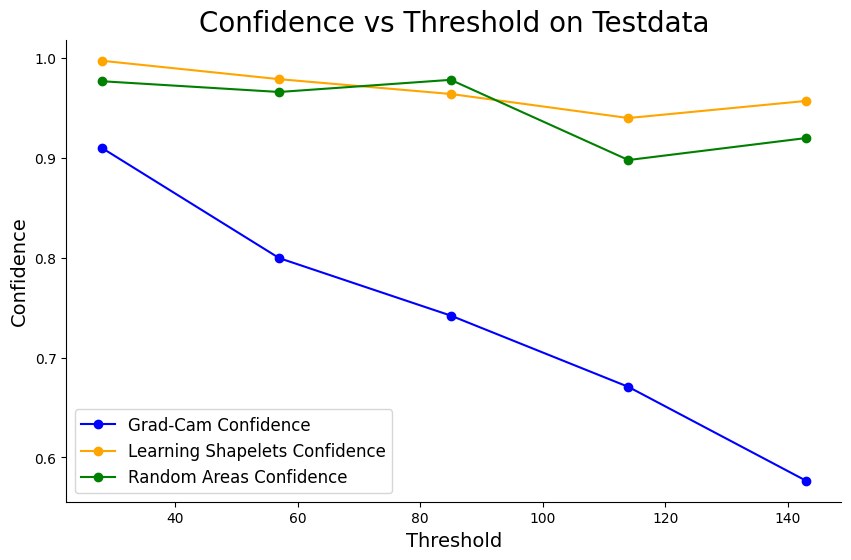

In [194]:
# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines
ax.plot(df["avg_total_area_size_cnn"], df["cnn_test_confidence"], label="Grad-Cam Confidence", marker="o", color="blue")
ax.plot(df["avg_total_area_size_cnn"], df["ls_test_confidence"], label="Learning Shapelets Confidence", marker="o", color="orange")
ax.plot(df["avg_total_area_size_cnn"], df["rand_test_confidence"], label="Random Areas Confidence", marker="o", color="green")

# Customize plot
ax.set_title("Confidence vs Threshold on Testdata", fontsize=20)
ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Confidence", fontsize=14)
ax.legend(fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.invert_xaxis()

plt.savefig("images/test.png")
plt.show()

In [131]:
results

,dataset,threshold,number_of_shapelets,mode of cancellation,inverted,cnn_train_confidence,cnn_test_confidence,ls_train_confidence,ls_test_confidence,rand_train_confidence,rand_test_confidence,avg_total_area_size_cnn,avg_total_area_size_ls,avg_total_area_size_rand
0,Coffee,NaN,NaN,-,-,0.999829,0.993697,0.999829,0.993697,0.999829,0.993697,NaN,NaN,NaN
1,Coffee,0.9,1.0,zero,False,0.545746,0.461155,0.999702,0.924982,0.928540,NaN,12.839286,12.0,12.0
2,Coffee,0.9,1.0,linear,False,0.999020,0.963768,0.999834,0.986750,0.970423,NaN,12.839286,12.0,12.0
3,Coffee,0.9,1.0,mean,False,0.999509,0.961124,0.999816,0.988259,0.999537,NaN,12.839286,12.0,12.0
4,Coffee,0.9,1.0,zero,True,0.918468,0.941553,0.507619,0.416369,0.347927,NaN,12.839286,12.0,12.0
5,Coffee,0.9,1.0,linear,True,0.500001,0.535715,0.477932,0.466647,0.527733,NaN,12.839286,12.0,12.0
6,Coffee,0.9,1.0,mean,True,0.765121,0.803750,0.503348,0.577567,0.605629,NaN,12.839286,12.0,12.0
7,Coffee,0.9,2.0,zero,False,0.545746,0.461155,0.974261,0.871605,0.960870,NaN,12.839286,12.0,12.0
8,Coffee,0.9,2.0,linear,False,0.999020,0.963768,0.999839,0.993840,0.999791,NaN,12.839286,12.0,12.0
9,Coffee,0.9,2.0,mean,False,0.999509,0.961124,0.999794,0.993779,0.999686,NaN,12.839286,12.0,12.0


# Ansatz Dominik

In [93]:
dataset = datasets[1] ### Hier Datensatz auswählen
dataset_name = dataset["name"]

train_x, test_x, train_y, test_y = fetch_ucr_dataset(dataset["name"], return_X_y = True)
train_x, test_x = scale_dataset(train_x, test_x)

data = DataHandler(train_x, test_x, train_y, test_y)
dataset_name

'Coffee'

In [80]:
cnn_model = ClassificationModel(train_x, train_y)
cnn_model.fit(train_x, train_y, num_epochs=100)

Epoch [1/100], Loss: 0.7605
Epoch [2/100], Loss: 0.6974
Epoch [3/100], Loss: 0.6940
Epoch [4/100], Loss: 0.6931
Epoch [5/100], Loss: 0.6918
Epoch [6/100], Loss: 0.6900
Epoch [7/100], Loss: 0.6885
Epoch [8/100], Loss: 0.6842
Epoch [9/100], Loss: 0.6697
Epoch [10/100], Loss: 0.6687
Epoch [11/100], Loss: 0.6443
Epoch [12/100], Loss: 0.5947
Epoch [13/100], Loss: 0.5578
Epoch [14/100], Loss: 0.4865
Epoch [15/100], Loss: 0.4801
Epoch [16/100], Loss: 0.4447
Epoch [17/100], Loss: 0.4133
Epoch [18/100], Loss: 0.4597
Epoch [19/100], Loss: 0.3896
Epoch [20/100], Loss: 0.4395
Epoch [21/100], Loss: 0.3919
Epoch [22/100], Loss: 0.3580
Epoch [23/100], Loss: 0.3572
Epoch [24/100], Loss: 0.3505
Epoch [25/100], Loss: 0.3623
Epoch [26/100], Loss: 0.3657
Epoch [27/100], Loss: 0.3421
Epoch [28/100], Loss: 0.3438
Epoch [29/100], Loss: 0.3388
Epoch [30/100], Loss: 0.3402
Epoch [31/100], Loss: 0.3272
Epoch [32/100], Loss: 0.3251
Epoch [33/100], Loss: 0.3247
Epoch [34/100], Loss: 0.3337
Epoch [35/100], Loss: 0

In [91]:
ls_model = LearningShapelets(n_shapelets_per_size={20: 3}, scale=False)
ls_model.fit(train_x, train_y)

/Users/fabian/Coding/Uni/XAI-for-Time-Series/venv/lib/python3.10/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


LearningShapelets(n_shapelets_per_size={20: 3})

In [98]:
ls_areas = []
for x, y in [[train_x, train_y], [test_x, test_y]]:
    ls_areas.append(getAreasFromLearningShapelets(ls_model.locate(x), ls_model.shapelets_))

mls_train_x, mls_test_x, mls_train_y, mls_test_y = data.getData(how="mean", all_areas=ls_areas, invert=False)

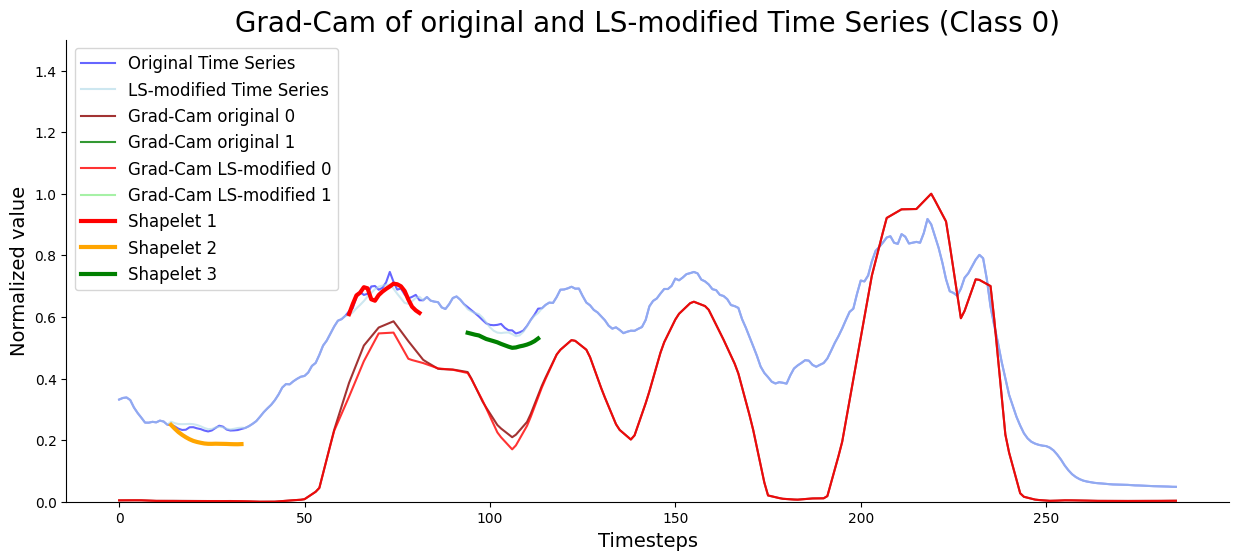

In [117]:
index = 5 ### Hier Sample zur Analyse auswählen

time_axis = np.arange(test_x.shape[1])
plt.figure(figsize=(15, 6))
plt.plot(time_axis, test_x[index], label="Original Time Series", color='blue', alpha=0.6)
plt.plot(time_axis, mls_test_x[index], label="LS-modified Time Series", color='lightblue', alpha=0.6)

cam_0 = cnn_model.grad_cam(index, test_x, test_y, 0)
cam_1 = cnn_model.grad_cam(index, test_x, test_y, 1)
gradcam_original = np.fmax(cam_0, cam_1)
# plt.plot(time_axis, gradcam_original, alpha=0.8, label="Grad-Cam original", color="green")
plt.plot(time_axis, cam_0, alpha=0.8, label="Grad-Cam original 0", color="darkred")
plt.plot(time_axis, cam_1, alpha=0.8, label="Grad-Cam original 1", color="green")


cam_0 = cnn_model.grad_cam(index, mls_test_x, mls_test_y, 0)
cam_1 = cnn_model.grad_cam(index, mls_test_x, mls_test_y, 1)
gradcam_modified = np.fmax(cam_0, cam_1)
# plt.plot(time_axis, gradcam_modified, alpha=0.8, label="Grad-Cam LS-modified", color="lightgreen")
plt.plot(time_axis, cam_0, alpha=0.8, label="Grad-Cam LS-modified 0", color="red")
plt.plot(time_axis, cam_1, alpha=0.8, label="Grad-Cam LS-modified 1", color="lightgreen")

colors = ["red", "orange", "green", "black", "purple"]
predicted_locations = ls_model.locate(test_x)
for id_shap in range(len(ls_model.shapelets_)):
    shap = ls_model.shapelets_[id_shap]
    pos = predicted_locations[index, id_shap]
    plt.plot(np.arange(pos, pos + len(shap)), shap, linewidth=3, color=colors[id_shap], label=f"Shapelet {id_shap+1}")


plt.gca().set_ylim([0, 1.5])
plt.gca().set_ylabel("Normalized value", fontdict={'fontsize' : 14})
plt.gca().set_xlabel("Timesteps", fontdict={'fontsize' : 14})
plt.gca().set_title(f"Grad-Cam of original and LS-modified Time Series (Class {test_y[index]})", fontdict = {'fontsize' : 20})
plt.legend(prop={'size': 12})
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()

In [71]:
l2_distance = np.sum(np.square(gradcam_original - gradcam_modified))
l2_distance

2.8552847